# SXR Energy Profile

In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_format = 'retina'
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from lcls_live.datamaps import get_datamaps
from lcls_live.archiver import lcls_archiver_restore

from pytao import Tao

import os

In [3]:
BEAMPATH = 'cu_sxr'

## Datamaps, and all PVs needed

In [4]:
DM = get_datamaps(BEAMPATH)

DM.keys()

dict_keys(['bpms', 'correctors', 'subboosters', 'linac', 'K21_1', 'K21_2', 'K21_3', 'K21_4', 'K21_5', 'K21_6', 'K21_7', 'K21_8', 'K22_1', 'K22_2', 'K22_3', 'K22_4', 'K22_5', 'K22_6', 'K22_7', 'K22_8', 'K23_1', 'K23_2', 'K23_3', 'K23_4', 'K23_5', 'K23_6', 'K23_7', 'K23_8', 'K24_1', 'K24_2', 'K24_3', 'K24_4', 'K24_5', 'K24_6', 'K25_1', 'K25_2', 'K25_3', 'K25_4', 'K25_5', 'K25_6', 'K25_7', 'K25_8', 'K26_1', 'K26_2', 'K26_3', 'K26_4', 'K26_5', 'K26_6', 'K26_7', 'K26_8', 'K27_1', 'K27_2', 'K27_3', 'K27_4', 'K27_5', 'K27_6', 'K27_7', 'K27_8', 'K28_1', 'K28_2', 'K28_3', 'K28_4', 'K28_5', 'K28_6', 'K28_7', 'K28_8', 'K29_1', 'K29_2', 'K29_3', 'K29_4', 'K29_5', 'K29_6', 'K29_7', 'K29_8', 'K30_1', 'K30_2', 'K30_3', 'K30_4', 'K30_5', 'K30_6', 'K30_7', 'K30_8', 'quad', 'beginning_WS02', 'tao_energy_measurements'])

In [5]:

# datamaps to exclude
DENYLIST = ['beginning_WS02', 'quad', 'correctors', 'bpms']

# PVs needed
ALLPVS =  []
for name, dm in DM.items():
    if name in DENYLIST:
        continue
    ALLPVS.extend(dm.pvlist)
ALLPVS = list(set(ALLPVS))


len(ALLPVS)

553

## Archiver restore

In [6]:
ISOTIME = '2021-12-01T16:45:00.000000-08:00'

In [7]:
# Optional: 

# Open an SSH tunnel in a terminal like:
# ssh -D 8080 <some user>@<some SLAC machine>
# And then set:
os.environ['http_proxy']='socks5h://localhost:8080'
os.environ['HTTPS_PROXY']='socks5h://localhost:8080'
os.environ['ALL_PROXY']='socks5h://localhost:8080'

In [8]:
PVDATA = lcls_archiver_restore(ALLPVS, ISOTIME)
len(PVDATA)

Requesting: http://lcls-archapp.slac.stanford.edu/retrieval/data/getDataAtTime?at=2021-12-01T16:45:00.000000-08:00&includeProxies=true


553

## Form commands using PVDATA and datamaps

In [21]:
CMDS = []
for name, dm in DM.items():
    CMDS.extend(dm.as_tao(PVDATA))

CMDS[0:5]

['! Bad value for orbit.x[1][]: None',
 '! Bad value for orbit.x[2][]: None',
 '! Bad value for orbit.x[3][]: None',
 '! Bad value for orbit.x[4][]: None',
 '! Bad value for orbit.x[5][]: None']

In [22]:
# Write to file for running with vanilla Tao
with open('cmds.tao', 'w') as f:
    f.write('set global lattice_calc_on = F\n')
    f.write('set global plot_on = F\n')    
    for cmd in CMDS:
        f.write(cmd+'\n')
    f.write('set global lattice_calc_on = T\n')        
    f.write('set global plot_on = T\n')            

# Examine klystrons

In [23]:
from lcls_live.datamaps.klystron import klystron_pvinfo
d = klystron_pvinfo(24, 2, beamcode=2)
d

{'name': 'K24_2',
 'sector': 24,
 'station': 2,
 'description': 'Klystron in sector 24, station 2, beamcode 2 for special feedback',
 'enld_pvname': 'KLYS:LI24:21:ENLD',
 'phase_pvname': 'ACCL:LI24:200:KLY_PDES:SETDATA_2',
 'accelerate_pvname': 'KLYS:LI24:21:BEAMCODE2_STAT',
 'swrd_pvname': 'KLYS:LI24:21:SWRD',
 'stat_pvname': 'KLYS:LI24:21:STAT',
 'hdsc_pvname': 'KLYS:LI24:21:HDSC',
 'dsta_pvname': 'KLYS:LI24:21:DSTA'}

In [24]:
d2 = {}
for k in d:
    if k.endswith('_pvname'):
        d2[k] = PVDATA[d[k]]
d2        

{'enld_pvname': 178.02,
 'phase_pvname': -85.54768846080982,
 'accelerate_pvname': 1.0,
 'swrd_pvname': 128,
 'stat_pvname': 33,
 'hdsc_pvname': 1.0,
 'dsta_pvname': [1610612737.0, 528640.0]}

# Start Tao



In [27]:
init = f'-init $LCLS_LATTICE/bmad/models/{BEAMPATH}/tao.init'
init

'-init $LCLS_LATTICE/bmad/models/cu_sxr/tao.init'

In [28]:
tao = Tao(init)

In [29]:
%%tao
place floor energy

-------------------------
Tao> place floor energy
-------------------------
Tao> 


In [30]:
# apply commands all at once
tao.cmds(CMDS);

(0.0, 4.5)

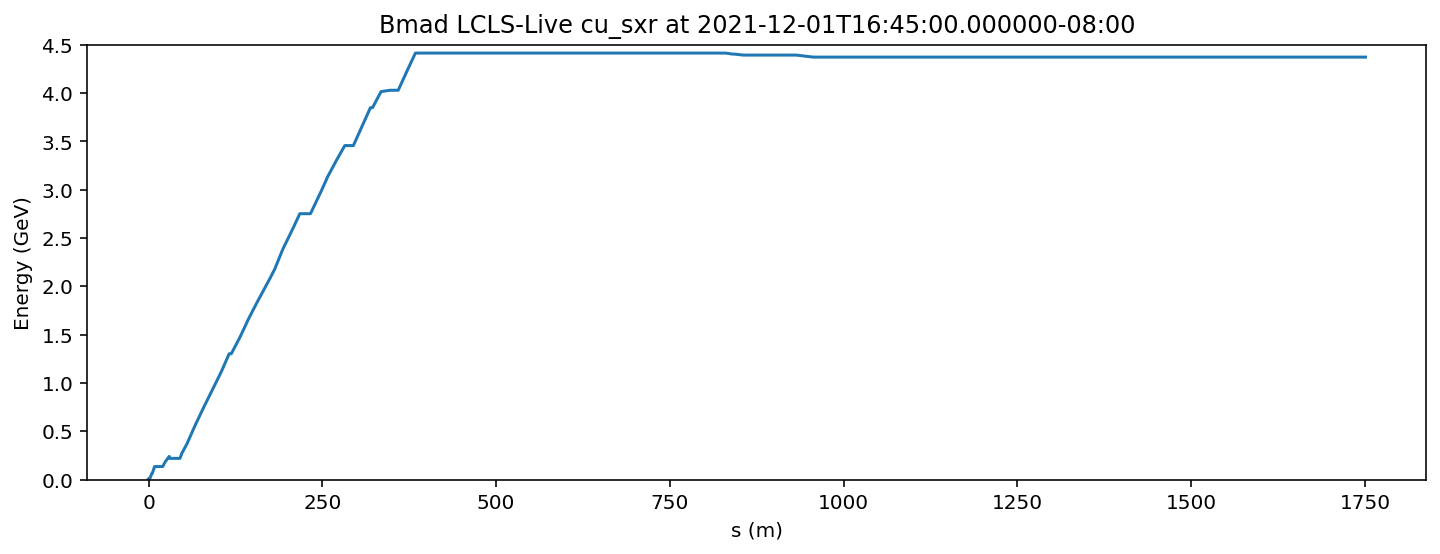

In [31]:
s = tao.lat_list('*', 'ele.s')
e_tot = tao.lat_list('*', 'ele.e_tot')

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(s, e_tot/1e9)
ax.set_xlabel('s (m)')
ax.set_ylabel('Energy (GeV)')
ax.set_title(f'Bmad LCLS-Live {BEAMPATH} at {ISOTIME}')
ax.set_ylim(0, 4.5)

In [32]:
%%tao
sho ele endbc2

-------------------------
Tao> sho ele endbc2
Element # 755
Element Name: ENDBC2
Key: Marker
S_start, S:    423.734561,    423.734561
Ref_time:  1.413449E-06

Attribute values [Only non-zero values shown]:
    1  L                           =  0.0000000E+00 m
    5  CRUNCH                      =  0.0000000E+00 rad
    6  NOISE                       =  0.0000000E+00
    7  OSC_AMPLITUDE               =  0.0000000E+00 m
   21  CRUNCH_CALIB                =  0.0000000E+00 rad
   24  TILT_CALIB                  =  0.0000000E+00 rad
   25  DE_ETA_MEAS                 =  0.0000000E+00
   26  N_SAMPLE                    =  0.0000000E+00
   50  DELTA_REF_TIME              =  0.0000000E+00 sec
   53  P0C                         =  4.4135203E+09 eV           BETA                        =  9.9999999E-01
   54  E_TOT                       =  4.4135203E+09 eV           GAMMA                       =  8.6370438E+03

       TRACKING_METHOD              =  Bmad_Standard             APERTURE_AT         